In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 200, canonicalize_fmap=None
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 200, canonicalize_fmap=None
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.64it/s]


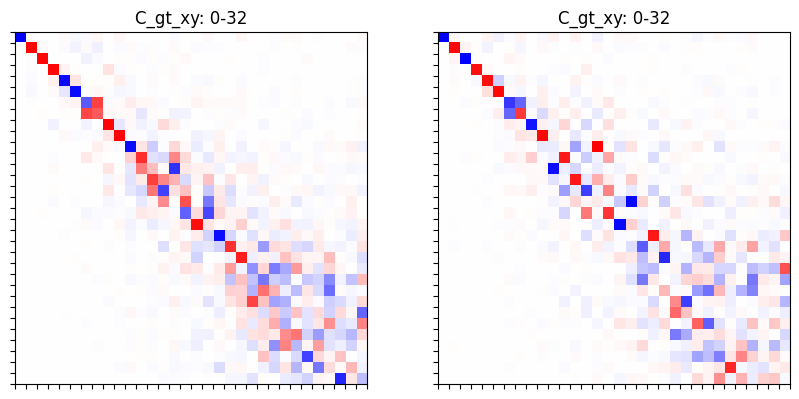

In [3]:
import my_code.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], test_dataset[1]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)

plt.show()

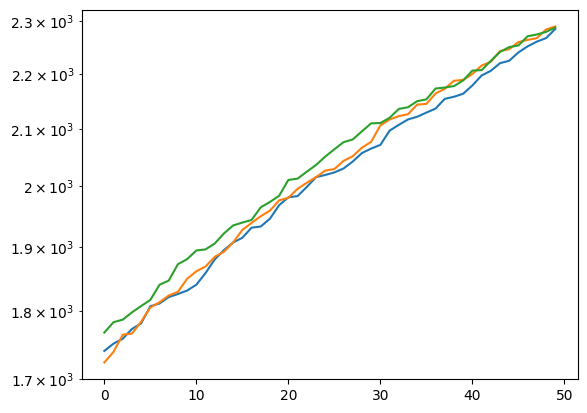

In [18]:
l = 150
h = 200

plt.plot(train_dataset[55]['second']['evals'][0][l:h], label='evals_67')
plt.plot(train_dataset[67]['second']['evals'][0][l:h], label='evals_67')
plt.plot(train_dataset[78]['second']['evals'][0][l:h], label='evals_78')

plt.yscale('log')

plt.show()

In [ ]:
def predict_sign_change(net, verts, faces, evecs_flip, evecs_cond):
    
    # normalize the evecs
    evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
    
    if evecs_cond is not None:
        evecs_cond = torch.nn.functional.normalize(evecs_cond, p=2, dim=1)
        evecs_input = torch.cat([evecs_flip, evecs_cond], dim=-1)
    else:
        evecs_input = evecs_flip
        
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]

    # normalize the support vector
    support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)
    
    # multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
    product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip

    if product_with_support.shape[1] == product_with_support.shape[2]:
        # take only diagonal elements
        product_with_support = torch.diagonal(product_with_support, dim1=1, dim2=2)
        
    # get the sign of the support vector
    sign_flip_predicted = product_with_support
 
    return sign_flip_predicted, support_vector_norm

In [ ]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0
feature_dim = 64


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim + condition_dim,
    out_channels=feature_dim,
    # hidden_channels=feature_dim // 2,
    cache_dir=f'data_with_smpl_corr/FAUST_original/{200}',
    input_type='wks',
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


loss_fn = torch.nn.MSELoss()
losses = torch.tensor([])
iterator = tqdm(range(30001))

possible_shapes = [train_dataset[i]['second'] for i in range(len(train_dataset))]
# possible_shapes = [train_dataset[i]['second'] for i in range(2)]
                   
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    curr_idx = np.random.randint(0, len(possible_shapes))
    
    train_shape = possible_shapes[curr_idx]

    verts = train_shape['verts'].unsqueeze(0).to(device)
    faces = train_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = train_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

    # evecs_cond = None
    evecs_cond = train_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)

    ##############################################
    # Set the signs on shape 0
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_0[sign_gt_0 == 0] = -1
    sign_gt_0 = sign_gt_0.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_0 = evecs_orig * sign_gt_0
    
    # predict the sign change
    sign_pred_0 = predict_sign_change(net, verts, faces, evecs_flip_0, 
                                              evecs_cond=evecs_cond)[0]
    
    ##############################################
    # Set the signs on shape 1
    ##############################################
    
    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_1[sign_gt_1 == 0] = -1
    sign_gt_1 = sign_gt_1.float().unsqueeze(0)
    
    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_1 = evecs_orig * sign_gt_1
    
    # predict the sign change
    sign_pred_1 = predict_sign_change(net, verts, faces, evecs_flip_1, 
                                              evecs_cond=evecs_cond)[0]
    
    ##############################################
    # Calculate the loss
    ##############################################
    
    # calculate the ground truth sign difference
    sign_diff_gt = sign_gt_1 * sign_gt_0
    
    # calculate the sign difference between predicted evecs
    sign_diff_pred = sign_pred_1 * sign_pred_0
    
    # calculate the loss
    loss = loss_fn(
        sign_diff_pred.reshape(sign_diff_pred.shape[0], -1),
        sign_diff_gt.reshape(sign_diff_gt.shape[0], -1)
        )

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses = torch.cat([losses, torch.tensor([loss.item()])])
    
    # print mean of last 10 losses
    iterator.set_description(f'loss={torch.mean(losses[-10:]):.3f}')
    
    # plot the losses every 1000 iterations
    if i > 0 and i % (len(iterator) // 10) == 0:
        pd.Series(losses.numpy()).rolling(10).mean().plot()
        plt.yscale('log')
        plt.show()


In [ ]:
test_shapes_list = [test_dataset[i]['second'] for i in range(len(test_dataset))]
                   
iterator = tqdm(range(1001))

incorrect_signs_list = torch.tensor([])
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    # test_shape = test_shapes_list[i]
    
    curr_idx = np.random.randint(0, len(test_shapes_list))   
    test_shape = test_shapes_list[curr_idx]    

    verts = test_shape['verts'].unsqueeze(0).to(device)
    faces = test_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    evecs_cond = test_shape['evecs'][:,
        start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)


    ##############################################
    # Set the signs on shape 0
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_0[sign_gt_0 == 0] = -1
    sign_gt_0 = sign_gt_0.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_0 = evecs_orig * sign_gt_0
    
    # predict the sign change
    with torch.no_grad():
        sign_pred_0 = predict_sign_change(net, verts, faces, evecs_flip_0, 
                                              evecs_cond=evecs_cond)[0]
    
    ##############################################
    # Set the signs on shape 1
    ##############################################
    
    # create a random combilation of +1 and -1, length = feature_dim
    sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
    
    sign_gt_1[sign_gt_1 == 0] = -1
    sign_gt_1 = sign_gt_1.float().unsqueeze(0)
    
    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip_1 = evecs_orig * sign_gt_1
    
    # predict the sign change
    with torch.no_grad():
        sign_pred_1 = predict_sign_change(net, verts, faces, evecs_flip_1, 
                                              evecs_cond=evecs_cond)[0]
    
    ##############################################
    # Calculate the loss
    ##############################################
    
    # calculate the ground truth sign difference
    sign_diff_gt = sign_gt_1 * sign_gt_0
    
    # calculate the sign difference between predicted evecs
    sign_diff_pred = sign_pred_1 * sign_pred_0
    
    sign_correct = sign_diff_pred.sign() * sign_diff_gt.sign() 
    
    
    # count the number of incorrect signs
    count_incorrect_signs = (sign_correct < 0).int().sum()
    # incorrect_signs_list.append(count_incorrect_signs)
    incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
    
    
    iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}')
    
    
print(f'Results for {len(incorrect_signs_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_signs_list.float().mean():.2f} / {feature_dim}')

# print('Shape idx', curr_idx)
print('GT', sign_diff_gt)
print('PRED', sign_diff_pred)
print('Correct', sign_correct)
print(f'Incorrect signs {torch.sum(sign_correct != 1)} / {feature_dim}')

# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()


In [ ]:
C_xy_pred_list = torch.tensor([])

for i in range(len(train_dataset)):
    # data_0 = test_dataset[12]
    data_0 = train_dataset[i]

    verts_first = data_0['first']['verts'].unsqueeze(0).to(device)
    verts_second = data_0['second']['verts'].unsqueeze(0).to(device)

    evecs_first = data_0['first']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    evecs_second = data_0['second']['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)

    corr_first = data_0['first']['corr']
    corr_second = data_0['second']['corr']

    C_gt_xy = data_0['second']['C_gt_xy'][0]

    # predict the sign change
    with torch.no_grad():
        sign_pred_first = predict_sign_change(net, verts_first, faces, evecs_first, 
                                                evecs_cond=None)[0]
        sign_pred_second = predict_sign_change(net, verts_second, faces, evecs_second, 
                                                evecs_cond=None)[0]

    C_xy_pred = torch.linalg.lstsq(
        evecs_second.cpu()[0, corr_second] * torch.sign(sign_pred_second).cpu(),
        evecs_first.cpu()[0, corr_first] * torch.sign(sign_pred_first).cpu()
        ).solution
    
    C_xy_pred_list = torch.cat([C_xy_pred_list, C_xy_pred.unsqueeze(0)])


In [ ]:
l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_xy_pred_list[0], 'C_xy_pred_list[0]', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_pred_list[1], 'C_xy_pred_list[12]', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_xy_pred_list[2], 'C_xy_pred_list[26]', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

C_xy_pred_list_scaled = scaler.fit_transform(C_xy_pred_list.reshape(C_xy_pred_list.shape[0], -1))
C_xy_pred_list_pca = pca.fit_transform(C_xy_pred_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(C_xy_pred_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(C_xy_pred_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_pred_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')
plt.show()



plt.show()